In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pickle

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, GeneralizingEstimator, Scaler, cross_val_multiscore, LinearModel, get_coef, Vectorizer, CSP

In [3]:
# Read epochs
epochs = mne.read_epochs('data_tmp\\subj_{}-epo.fif'.format(0), preload=True)

Reading f:\MYPROJECTS16\project_demoMNEpython\data_tmp\subj_0-epo.fif ...
    Read a total of 2 projection items:
        EOG-planar--0.200-0.200-PCA-01 (1 x 204) active
        EOG-axial--0.200-0.200-PCA-01 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
418 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
2 projection items activated


In [4]:
# Contrasts for decoding
contrast = {}
contrast[0] = ['animate', 'inanimate']
contrast[1] = ['face', 'body']
contrast[2] = ['male', 'female']
contrast[3] = ['natural', 'artificial']
contrast[4] = ['human/face', 'animal/face']
contrast[5] = ['human/body', 'animal/body']

In [5]:
# Design classifier
clf = make_pipeline(StandardScaler(), svm.SVC(kernel='linear', C=1))
time_decod = SlidingEstimator(clf, n_jobs=24, scoring='roc_auc', verbose=True)

In [7]:
# Run decoding (time-resolved, i.e. separate classifier per time point)
c=4 # select contrast
X1 = epochs[contrast[c][0]].get_data(picks='meg').copy()
X2 = epochs[contrast[c][1]].get_data(picks='meg').copy()
X = np.concatenate((X1, X2), axis=0)
y1 = ['labelA'] * X1.shape[0]
y2 = ['labelB'] * X2.shape[0]
y = y1 + y2
starttime = timeit.default_timer()
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)  # cross validated decoding (n_jobs is equal to folds; does not help with more)
print('Processing time for decoding: {:.2f} sec'.format(timeit.default_timer() - starttime))
Scores = np.mean(scores, axis=0)  # Mean scores across cross-validation splits

  0%|          | Fitting SlidingEstimator : 0/250 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/250 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/250 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/250 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/250 [00:00<?,       ?it/s]

Processing time for decoding: 19.95 sec


In [10]:
f'decoding {contrast[4]}'

"decoding ['human/face', 'animal/face']"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, "Decoding ['human/face', 'animal/face']")

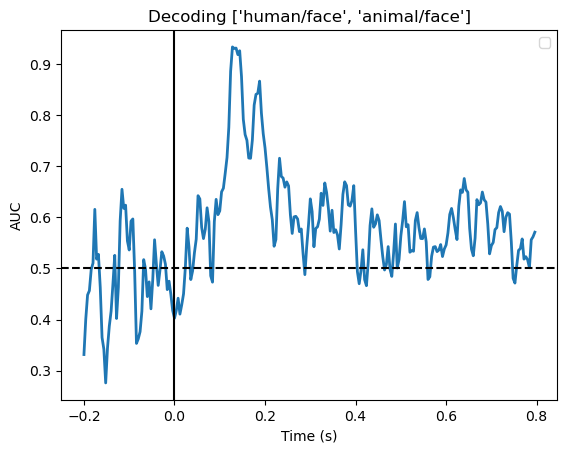

In [11]:
## plot decoding time course
fig, ax = plt.subplots()
ax.plot(epochs.times, Scores, linewidth=2)
ax.axhline(.5, color='k', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title(f'Decoding {contrast[4]}')